<a href="https://colab.research.google.com/github/fangyiyu/Fake_News_Detection_Flask/blob/main/Fake_news_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

In [ ]:
%cd /content/gdrive/My Drive/Kaggle

/content/gdrive/My Drive/Kaggle


In [ ]:
!kaggle datasets download clmentbisaillon/fake-and-real-news-dataset

 88% 36.0M/41.0M [00:01<00:00, 24.5MB/s]
100% 41.0M/41.0M [00:01<00:00, 29.2MB/s]


In [ ]:
!ls

Fake.csv     model2.pkl  random_dataset.csv  tfidfvect.pkl
kaggle.json  model.pkl	 tfidfvect2.pkl      True.csv


In [ ]:
#unzipping the zip files and deleting the zip files
!unzip \*.zip  && rm *.zip

Archive:  fake-and-real-news-dataset.zip
replace Fake.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: Fake.csv                
replace True.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: True.csv                


In [ ]:
import pandas as pd

In [ ]:
true = pd.read_csv('True.csv')

In [ ]:
true.head(3)

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"


In [ ]:
true.shape

(21417, 4)

In [ ]:
fake = pd.read_csv('Fake.csv')
fake.shape

(23481, 4)

In [ ]:
true['label'] = 1
fake['label'] = 0

In [ ]:
# Use the the first 5000 data of true and fake dataset for building the model.
frames = [true.loc[:5000][:], fake.loc[:5000][:]]

In [ ]:
df = pd.concat(frames)

In [ ]:
df.shape

(10002, 5)

In [ ]:
df.tail()

,title,text,subject,date,label
4996,Justice Department Announces It Will No Longe...,Republicans are about to lose a huge source of...,News,"August 18, 2016",0
4997,WATCH: S.E. Cupp Destroys Trump Adviser’s ‘Fa...,A pawn working for Donald Trump claimed that w...,News,"August 18, 2016",0
4998,WATCH: Fox Hosts Claim Hillary Has Brain Dama...,Fox News is desperate to sabotage Hillary Clin...,News,"August 18, 2016",0
4999,CNN Panelist LAUGHS In Corey Lewandowski’s Fa...,As Donald Trump s campaign continues to sink d...,News,"August 18, 2016",0
5000,Trump Supporter Who Wants To Shoot Black Kids...,"Hi folks, John Harper here, at least if you as...",News,"August 18, 2016",0


In [ ]:
X = df. drop('label', axis=1)
y = df['label']

In [ ]:
df = df.dropna()
df2 = df.copy()

In [ ]:
df2.head()

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [ ]:
df2.reset_index(inplace=True)
df2.head()

,index,title,text,subject,date,label
0,0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [ ]:
df2['title'][2]

"Senior U.S. Republican senator: 'Let Mr. Mueller do his job'"

**Data Preprocessing**

In [ ]:
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()

In [ ]:
import re
import nltk
nltk.download('stopwords')

corpus = []
for i in range(0, len(df2)):
    review = re.sub('[^a-zA-Z]', ' ', df2['text'][i])
    review = review.lower()
    review = review.split()
    
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# TFidf Vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_v = TfidfVectorizer(max_features=5000, ngram_range=(1,3))

In [ ]:
X = tfidf_v.fit_transform(corpus).toarray()
y = df2['label']

In [ ]:
# Divide the dataset into Train and Test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

**Model building - Passive Aggresive Classifier**

In [ ]:
from sklearn.linear_model import PassiveAggressiveClassifier
classifier = PassiveAggressiveClassifier(max_iter=1000)

In [ ]:
from sklearn import metrics
import numpy as np
import itertools

classifier.fit(X_train, y_train)

pred = classifier.predict(X_test)

score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)

accuracy:   0.999


In [ ]:
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    See full source and example: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


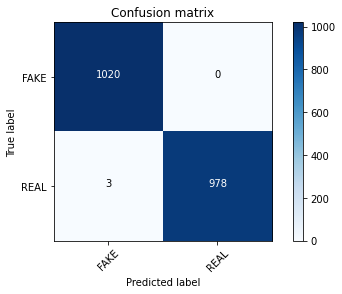

In [ ]:
cm = metrics.confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

**Validate on an unseen datapoint**

In [ ]:
review = re.sub('[^a-zA-Z]', ' ', fake['text'][13070])
review = review.lower()
review = review.split()
    
review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
review = ' '.join(review)
review

'mani c word hillari compet one ouch'

In [ ]:
val = tfidf_v.transform([review]).toarray()

In [ ]:
classifier.predict(val)

array([0])

**Save model and vectorizer**

In [ ]:
import pickle

In [ ]:
pickle.dump(classifier, open('model2.pkl', 'wb'))

In [ ]:
pickle.dump(tfidf_v, open('tfidfvect2.pkl', 'wb'))

**Load model and vectorizer to predict the previous datapoint**

In [ ]:
joblib_model = pickle.load(open('model2.pkl', 'rb'))

In [ ]:
joblib_vect = pickle.load(open('tfidfvect2.pkl', 'rb'))

In [ ]:
val_pkl = joblib_vect.transform([review]).toarray()

In [ ]:
joblib_model.predict(val_pkl)

array([0])